## Counters

* [`/agas{locality#*/total}/count/bind_gid`](#Bind-GID)
* [`/agas{locality#*/total}/count/unbind_gid`](#Unbind-GID)
* [`/agas{locality#*/total}/count/resolve_gid`](#Resolve-GID)
* [`/agas{locality#*/total}/time/resolve_gid`](#Resolve-GID)
***
* [`/agas{locality#*/total}/count/route`](#Route)
* [`/agas{locality#*/total}/time/route`](#Route)
* [`/agas{locality#*/total}/count/resolve_locality`](#Resolve-Locality)
* [`/agas{locality#*/total}/time/resolve_locality`](#Resolve-Locality)
***
* [`/agas{locality#*/total}/count/decrement_credit`](#Decrement-Credit)
* [`/agas{locality#*/total}/time/decrement_credit`](#Decrement-Credit)
* [`/agas{locality#*/total}/count/increment_credit`](#Increment-Credit)
* [`/agas{locality#*/total}/time/increment_credit`](#Increment-Credit)
***
* [`/agas{locality#*/total}/count/cache/hits`](#AGAS-Cache-Hit-Rate)
* [`/agas{locality#*/total}/count/cache/misses`](#AGAS-Cache-Hit-Rate)
* [`/agas{locality#*/total}/time/cache/insert_entry`](#Insert-Entry)
* [`/agas{locality#*/total}/count/cache/update_entry`](#Update-Entry)
* [`/agas{locality#*/total}/time/cache/update_entry`](#Update-Entry)
* [`/agas{locality#*/total}/time/cache/get_entry`](#Get-Entry)
* [`/agas{locality#*/total}/time/cache/erase_entry`](#Erase-Entry)

### Notebook Preps

In [1]:
%matplotlib inline
%matplotlib notebook
#%matplotlib nbagg

In [2]:
import re

In [3]:
import numpy as np
import pandas as pd
#import scipy as sp

import matplotlib
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

In [4]:
def percent_formatter(y, position):
    # Ignore the passed in position. This has the effect of scaling the default
    # tick locations.
    s = str(100 * y)

    # The percent symbol needs escaping in latex
    if matplotlib.rcParams['text.usetex'] is True:
        return s + r'$\%$'
    else:
        return s + '%'

PercentFormatter = ticker.FuncFormatter(percent_formatter)

---

## Performance Counter Parsing RegEx

In [5]:
locality_regex = re.compile('/agas\{locality#(\d+)[^}]*\}')

In [6]:
pfx_counter_regex = re.compile(
    '/([a-z_]+){locality#(\d+)/total}/(?:(?:(count|time)/)'
    '([a-z/_-]+)|([a-z/_-]+)/(?:(count|time))),([0-9]+),'
    '([0-9.]+),\[[a-z]+\],([0-9.\+e]+)(?:,\[([a-z]+)?\])?'
)

## Read the Data Files

In [7]:
import zipfile

In [8]:
dataset = []

with zipfile.ZipFile('daint-28mar19_14_15.zip', 'r') as arxiv:
    for fn in arxiv.namelist():
        if fn.endswith('.out'):
            content = arxiv.read(fn).decode('utf-8')
            content = arxiv.read(fn).decode('utf-8')
            localities = set(int(x) for x in locality_regex.findall(content))
            if (localities):
                print('Processing "%s"...' % fn)
            else:
                print('No data found in "%s". Skipping...' % fn)
                continue
            node_count = max(localities) + 1
            
            for m in pfx_counter_regex.finditer(content):
                is_rev = m.group(3) != None

                dataset.append({
                    'sys': m.group(1),
                    'proc': (m.group(4) if is_rev else m.group(5)).replace('/', '.'),
                    'type': m.group(3) if is_rev else m.group(6),
                    'locality': int(m.group(2)),
                    'value': float(m.group(9)),
                    'value_unit': m.group(10),
                    'timestamp': m.group(8),
                    'iteration': int(m.group(7)),
                    'nodes': node_count,
                })

df = pd.DataFrame(dataset)

No data found in "parsa-12632971.out". Skipping...
No data found in "parsa-12632972.out". Skipping...
No data found in "parsa-12632973.out". Skipping...
No data found in "parsa-12632974.out". Skipping...
No data found in "parsa-12632976.out". Skipping...
No data found in "parsa-12632977.out". Skipping...
No data found in "parsa-12632978.out". Skipping...
No data found in "parsa-12632979.out". Skipping...
No data found in "parsa-12632980.out". Skipping...
No data found in "parsa-12632982.out". Skipping...
No data found in "parsa-12632983.out". Skipping...
No data found in "parsa-12632985.out". Skipping...
No data found in "parsa-12632986.out". Skipping...
No data found in "parsa-12632994.out". Skipping...
No data found in "parsa-12632995.out". Skipping...
No data found in "parsa-12632997.out". Skipping...
Processing "parsa-12632998.out"...
Processing "parsa-12633000.out"...
Processing "parsa-12633001.out"...
Processing "parsa-12633002.out"...
Processing "parsa-12633003.out"...
Processin

```python
import tarfile

dataset = []

with tarfile.open('cori-17mar17.tar.bz2', mode='r:bz2') as arxiv:
    for i in arxiv.getnames():
        if i.endswith('.txt'):
            n_nodes = int(i.split('.')[0])
            fd = arxiv.extractfile(i)
            for m in pfx_pattern.finditer(fd.read()):
                is_rev = m.group(3) != None

                dataset.append({
                    'sys': m.group(1),
                    'proc': (m.group(4) if is_rev else m.group(5)).replace('/', '.'),
                    'type': m.group(3) if is_rev else m.group(6),
                    'locality': int(m.group(2)),
                    'value': float(m.group(9)),
                    'value_unit': m.group(10),
                    'timestamp': m.group(8),
                    'iteration': int(m.group(7)),
                    'nodes': n_nodes,
                })

df = pd.DataFrame(dataset)
```

### Last Iteration

In [9]:
d = None
for i, j in df[['nodes', 'iteration']].groupby('nodes').max().iteration.to_dict().items():
    x = df[(df.nodes==i) & (df.iteration==j)]
    if d is None:
        d = x
    else:
        d = pd.concat([d, x])

In [10]:
print(d[(d.sys=='agas') & (d.type=='count')].proc.unique())
print(d[(d.sys=='agas') & (d.type=='time')].proc.unique())

['route' 'bind_gid' 'unbind_gid' 'resolve_gid' 'increment_credit'
 'decrement_credit' 'allocate' 'begin_migration' 'end_migration'
 'bind_prefix' 'bind_name' 'unbind_name' 'resolve_id' 'iterate_types'
 'get_component_typename' 'num_localities_type' 'free' 'localities'
 'num_localities' 'resolve_locality' 'num_threads' 'bind' 'unbind'
 'resolve' 'iterate_names' 'on_symbol_namespace_event' 'cache.entries'
 'cache.insertions' 'cache.evictions' 'cache.hits' 'cache.misses'
 'cache.get_entry' 'cache.insert_entry' 'cache.update_entry'
 'cache.erase_entry' 'primary' 'component' 'locality' 'symbol']
['route' 'bind_gid' 'unbind_gid' 'resolve_gid' 'decrement_credit'
 'increment_credit' 'allocate' 'begin_migration' 'end_migration'
 'bind_prefix' 'bind_name' 'unbind_name' 'resolve_id' 'iterate_types'
 'get_component_typename' 'num_localities_type' 'free' 'localities'
 'num_localities' 'resolve_locality' 'num_threads' 'bind' 'unbind'
 'resolve' 'iterate_names' 'on_symbol_namespace_event' 'cache.get_

---

## GIDs

### Bind GID

(0.0, 584.3060706401767)

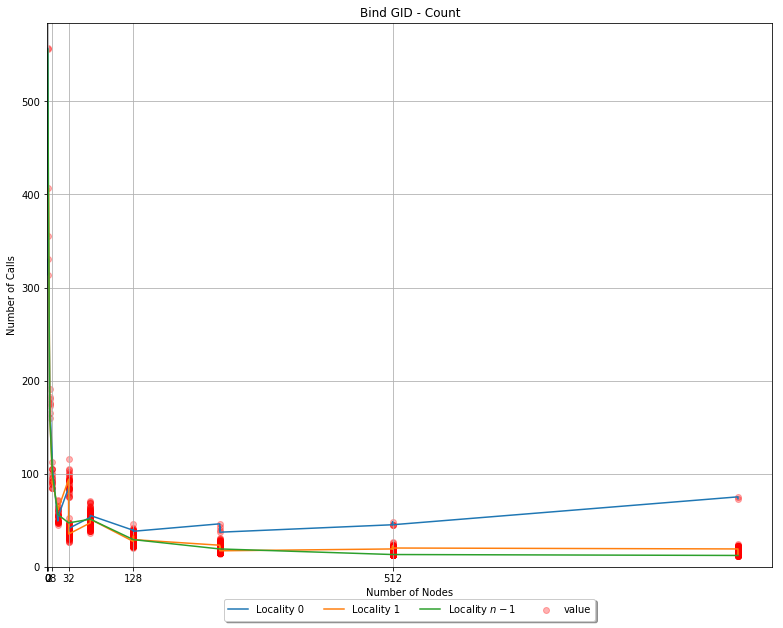

In [11]:
crt = d[(d.sys=='agas') & (d.proc=='bind_gid') & (d.type=='count')]

plt.figure(figsize=(13, 10))
plt.scatter(crt.nodes, crt.value, c='r', alpha=.3)
#
t = crt[crt.locality==0]
plt.plot(t.nodes, t.value, label='Locality 0')
#
t = crt[crt.locality==1]
plt.plot(t.nodes, t.value, label='Locality 1')
#
t = crt.groupby('nodes', as_index=False).last()
plt.plot(t.nodes, t.value, label='Locality $n - 1$')
#
plt.grid()

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
plt.title('Bind GID - Count')
plt.xlabel('Number of Nodes')
plt.ylabel('Number of Calls')

plt.gca().xaxis.set_major_locator(ticker.LogLocator(base=2))
plt.gca().set_xlim(left=0.)
plt.gca().set_ylim(bottom=0.)

### Unbind GID

(0.0, 553.3560706401767)

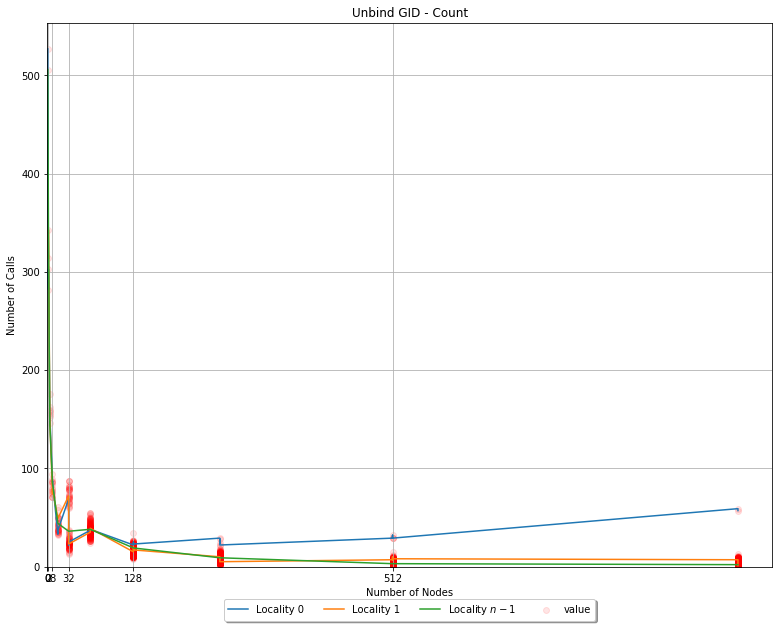

In [12]:
crt = d[(d.sys=='agas') & (d.proc=='unbind_gid') & (d.type=='count')]

plt.figure(figsize=(13, 10))
plt.scatter(crt.nodes, crt.value, c='r', alpha=.1)
#
t = crt[crt.locality==0]
plt.plot(t.nodes, t.value, label='Locality 0')
#
t = crt[crt.locality==1]
plt.plot(t.nodes, t.value, label='Locality 1')
#
t = crt.groupby('nodes', as_index=False).last()
plt.plot(t.nodes, t.value, label='Locality $n - 1$')
#
plt.grid()

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
plt.title('Unbind GID - Count')
plt.xlabel('Number of Nodes')
plt.ylabel('Number of Calls')

plt.gca().xaxis.set_major_locator(ticker.LogLocator(base=2))
plt.gca().set_xlim(left=0.)
plt.gca().set_ylim(bottom=0.)

### Resolve GID

(0.0, 44913904.60607064)

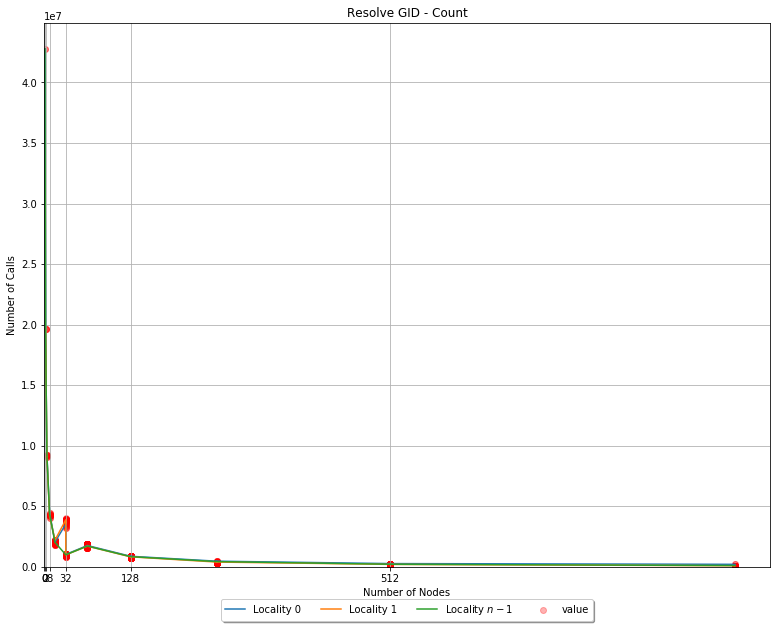

In [13]:
crt = d[(d.sys=='agas') & (d.proc=='resolve_gid') & (d.type=='count')]

plt.figure(figsize=(13, 10))
plt.scatter(crt.nodes, crt.value, c='r', alpha=.3)
#
t = crt[crt.locality==0]
plt.plot(t.nodes, t.value, label='Locality 0')
#
t = crt[crt.locality==1]
plt.plot(t.nodes, t.value, label='Locality 1')
#
t = crt.groupby('nodes', as_index=False).last()
plt.plot(t.nodes, t.value, label='Locality $n - 1$')
#
plt.grid()

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
plt.title('Resolve GID - Count')
plt.xlabel('Number of Nodes')
plt.ylabel('Number of Calls')

plt.gca().xaxis.set_major_locator(ticker.LogLocator(base=2))
plt.gca().set_xlim(left=0.)
plt.gca().set_ylim(bottom=0.)

[^ TOC ^](#Counters)

---

## Locality Namespace

### Route

(0.0, 1479.4560706401767)

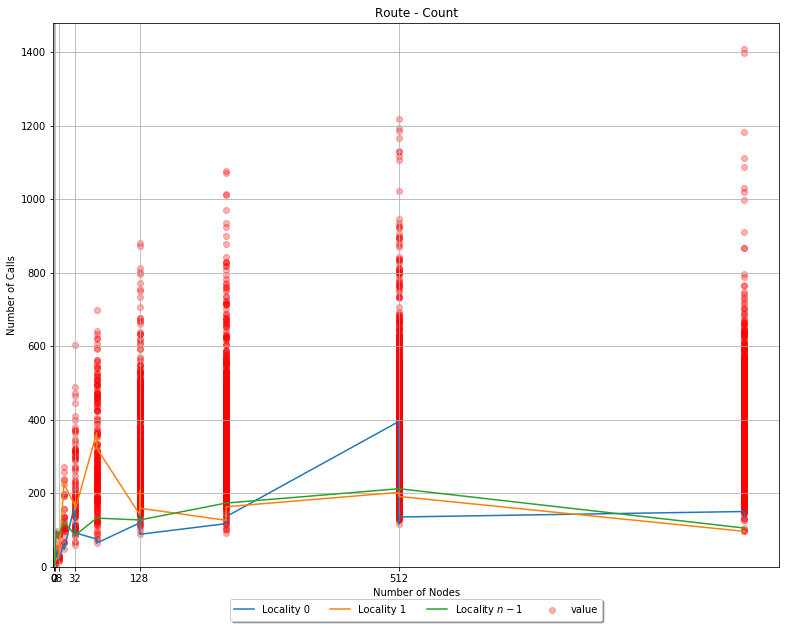

In [14]:
crt = d[(d.sys=='agas') & (d.proc=='route') & (d.type=='count')]

plt.figure(figsize=(13, 10))
plt.scatter(crt.nodes, crt.value, c='r', alpha=.3)
#
t = crt[crt.locality==0]
plt.plot(t.nodes, t.value, label='Locality 0')
#
t = crt[crt.locality==1]
plt.plot(t.nodes, t.value, label='Locality 1')
#
t = crt.groupby('nodes', as_index=False).last()
plt.plot(t.nodes, t.value, label='Locality $n - 1$')
#
plt.grid()

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
plt.title('Route - Count')
plt.xlabel('Number of Nodes')
plt.ylabel('Number of Calls')

plt.gca().xaxis.set_major_locator(ticker.LogLocator(base=2))
plt.gca().set_xlim(left=0.)
plt.gca().set_ylim(bottom=0.)

(0.0, 3130134000000.006)

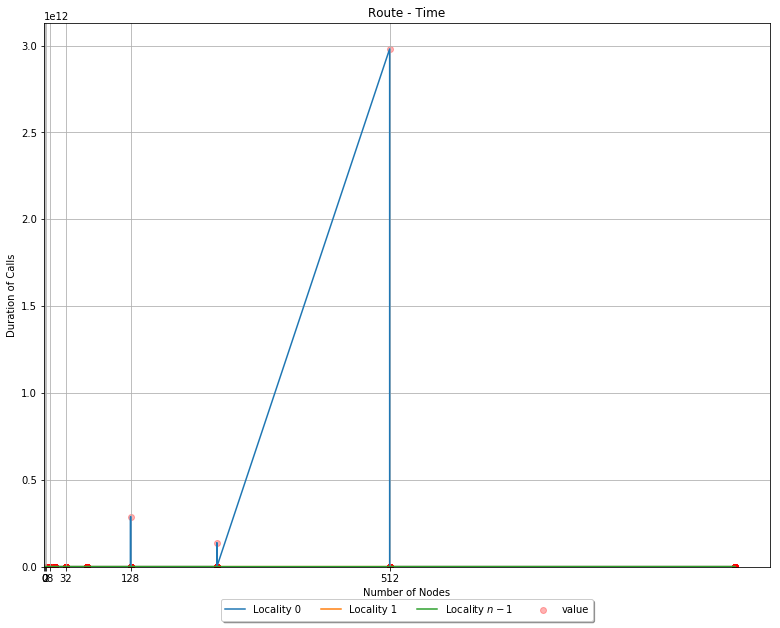

In [15]:
crt = d[(d.sys=='agas') & (d.proc=='route') & (d.type=='time')]

plt.figure(figsize=(13, 10))
plt.scatter(crt.nodes, crt.value, c='r', alpha=.3)
#
t = crt[crt.locality==0]
plt.plot(t.nodes, t.value, label='Locality 0')
#
t = crt[crt.locality==1]
plt.plot(t.nodes, t.value, label='Locality 1')
#
t = crt.groupby('nodes', as_index=False).last()
plt.plot(t.nodes, t.value, label='Locality $n - 1$')
#
plt.grid()

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
plt.title('Route - Time')
plt.xlabel('Number of Nodes')
plt.ylabel('Duration of Calls')

plt.gca().xaxis.set_major_locator(ticker.LogLocator(base=2))
plt.gca().set_xlim(left=0.)
plt.gca().set_ylim(bottom=0.)

[^ TOC ^](#Counters)

### Resolve Locality

(0.0, 0.006070640176600442)

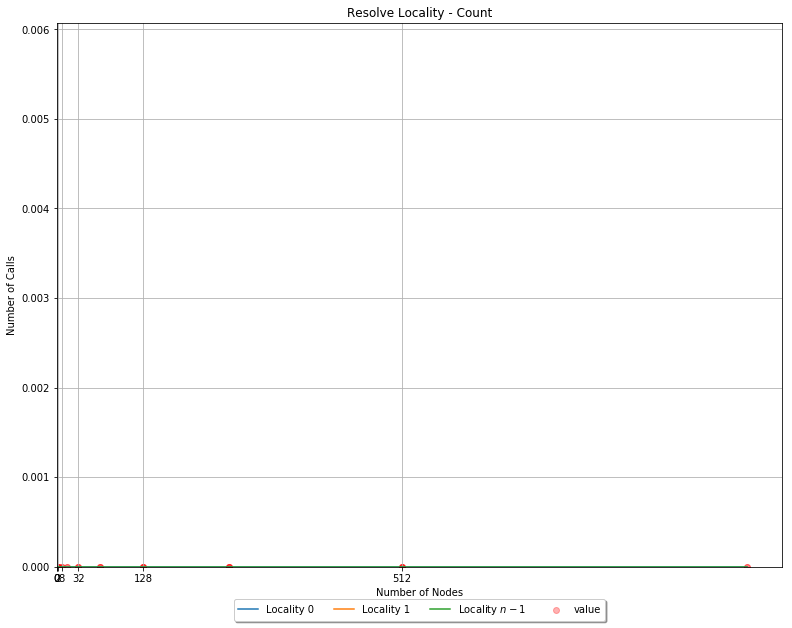

In [16]:
crt = d[(d.sys=='agas') & (d.proc=='resolve_locality') & (d.type=='count')]

plt.figure(figsize=(13, 10))
plt.scatter(crt.nodes, crt.value, c='r', alpha=.3)
#
t = crt[crt.locality==0]
plt.plot(t.nodes, t.value, label='Locality 0')
#
t = crt[crt.locality==1]
plt.plot(t.nodes, t.value, label='Locality 1')
#
t = crt.groupby('nodes', as_index=False).last()
plt.plot(t.nodes, t.value, label='Locality $n - 1$')
#
plt.grid()

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
plt.title('Resolve Locality - Count')
plt.xlabel('Number of Nodes')
plt.ylabel('Number of Calls')

plt.gca().xaxis.set_major_locator(ticker.LogLocator(base=2))
plt.gca().set_xlim(left=0.)
plt.gca().set_ylim(bottom=0.)

(0.0, 0.006070640176600442)

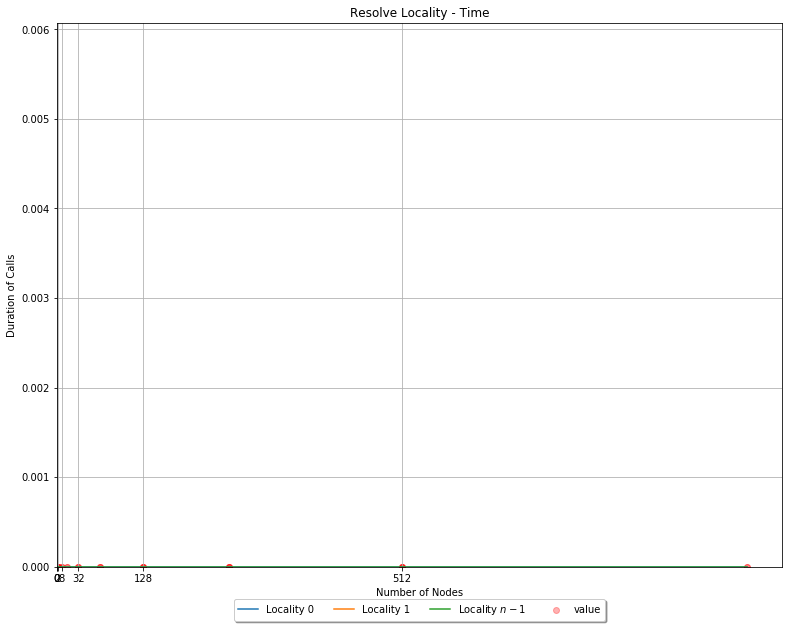

In [17]:
crt = d[(d.sys=='agas') & (d.proc=='resolve_locality') & (d.type=='time')]

plt.figure(figsize=(13, 10))
plt.scatter(crt.nodes, crt.value, c='r', alpha=.3)
#
t = crt[crt.locality==0]
plt.plot(t.nodes, t.value, label='Locality 0')
#
t = crt[crt.locality==1]
plt.plot(t.nodes, t.value, label='Locality 1')
#
t = crt.groupby('nodes', as_index=False).last()
plt.plot(t.nodes, t.value, label='Locality $n - 1$')
#
plt.grid()

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
plt.title('Resolve Locality - Time')
plt.xlabel('Number of Nodes')
plt.ylabel('Duration of Calls')

plt.gca().xaxis.set_major_locator(ticker.LogLocator(base=2))
plt.gca().set_xlim(left=0.)
plt.gca().set_ylim(bottom=0.)

[^ TOC ^](#Counters)

---

## Garbage Collection

### Increment Credit

(0.0, 1302.0060706401766)

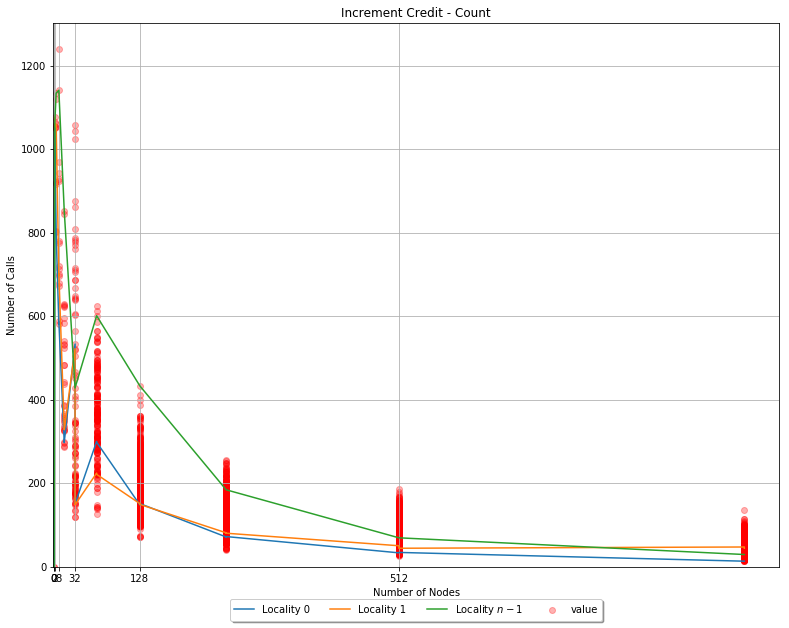

In [18]:
crt = d[(d.sys=='agas') & (d.proc=='increment_credit') & (d.type=='count')]

plt.figure(figsize=(13, 10))
plt.scatter(crt.nodes, crt.value, c='r', alpha=.3)
#
t = crt[crt.locality==0]
plt.plot(t.nodes, t.value, label='Locality 0')
#
t = crt[crt.locality==1]
plt.plot(t.nodes, t.value, label='Locality 1')
#
t = crt.groupby('nodes', as_index=False).last()
plt.plot(t.nodes, t.value, label='Locality $n - 1$')
#
plt.grid()

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
plt.title('Increment Credit - Count')
plt.xlabel('Number of Nodes')
plt.ylabel('Number of Calls')

plt.gca().xaxis.set_major_locator(ticker.LogLocator(base=2))
plt.gca().set_xlim(left=0.)
plt.gca().set_ylim(bottom=0.)

(0.0, 1217496.0060706402)

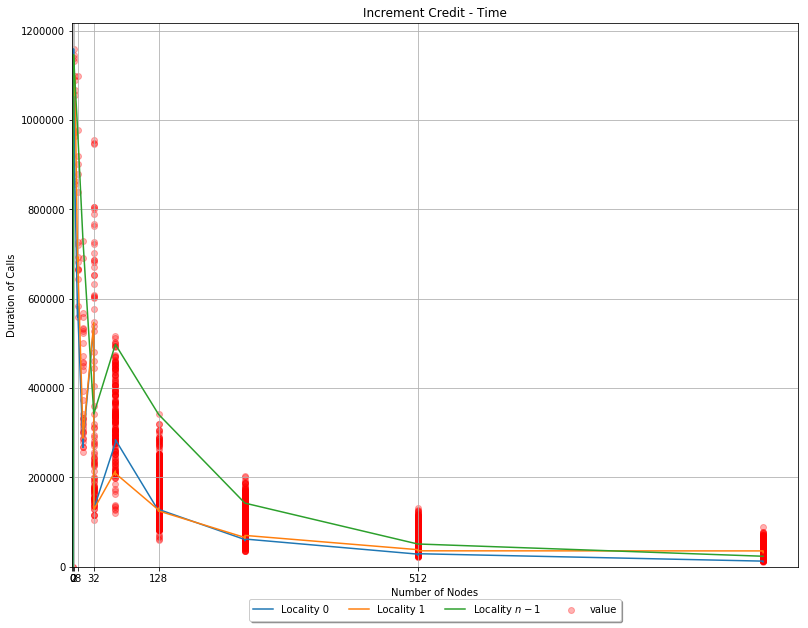

In [19]:
crt = d[(d.sys=='agas') & (d.proc=='increment_credit') & (d.type=='time')]

plt.figure(figsize=(13, 10))
plt.scatter(crt.nodes, crt.value, c='r', alpha=.3)
#
t = crt[crt.locality==0]
plt.plot(t.nodes, t.value, label='Locality 0')
#
t = crt[crt.locality==1]
plt.plot(t.nodes, t.value, label='Locality 1')
#
t = crt.groupby('nodes', as_index=False).last()
plt.plot(t.nodes, t.value, label='Locality $n - 1$')
#
plt.grid()

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
plt.title('Increment Credit - Time')
plt.xlabel('Number of Nodes')
plt.ylabel('Duration of Calls')

plt.gca().xaxis.set_major_locator(ticker.LogLocator(base=2))
plt.gca().set_xlim(left=0.)
plt.gca().set_ylim(bottom=0.)

[^ TOC ^](#Counters)

### Decrement Credit

(0.0, 2609.056070640177)

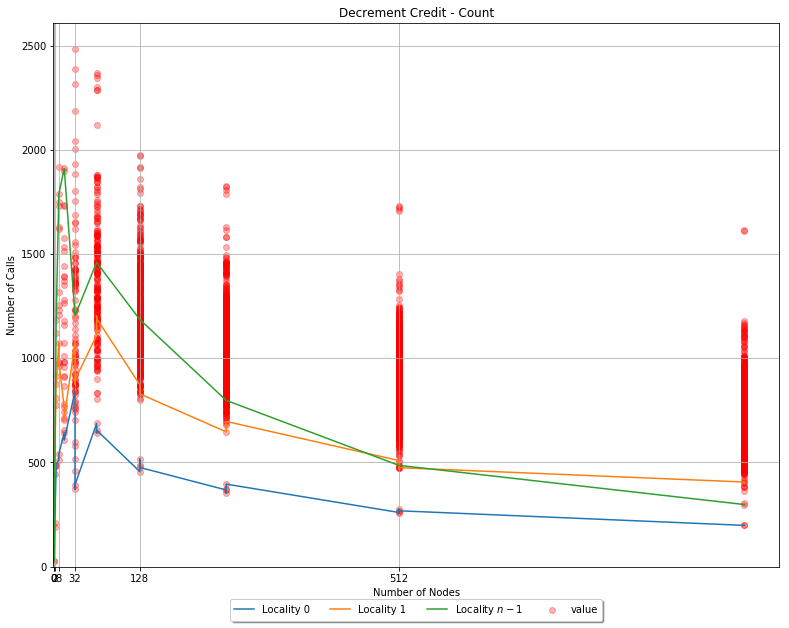

In [20]:
crt = d[(d.sys=='agas') & (d.proc=='decrement_credit') & (d.type=='count')]

plt.figure(figsize=(13, 10))
plt.scatter(crt.nodes, crt.value, c='r', alpha=.3)
#
t = crt[crt.locality==0]
plt.plot(t.nodes, t.value, label='Locality 0')
#
t = crt[crt.locality==1]
plt.plot(t.nodes, t.value, label='Locality 1')
#
t = crt.groupby('nodes', as_index=False).last()
plt.plot(t.nodes, t.value, label='Locality $n - 1$')
#
plt.grid()

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
plt.title('Decrement Credit - Count')
plt.xlabel('Number of Nodes')
plt.ylabel('Number of Calls')

plt.gca().xaxis.set_major_locator(ticker.LogLocator(base=2))
plt.gca().set_xlim(left=0.)
plt.gca().set_ylim(bottom=0.)

(0.0, 923218003.0060706)

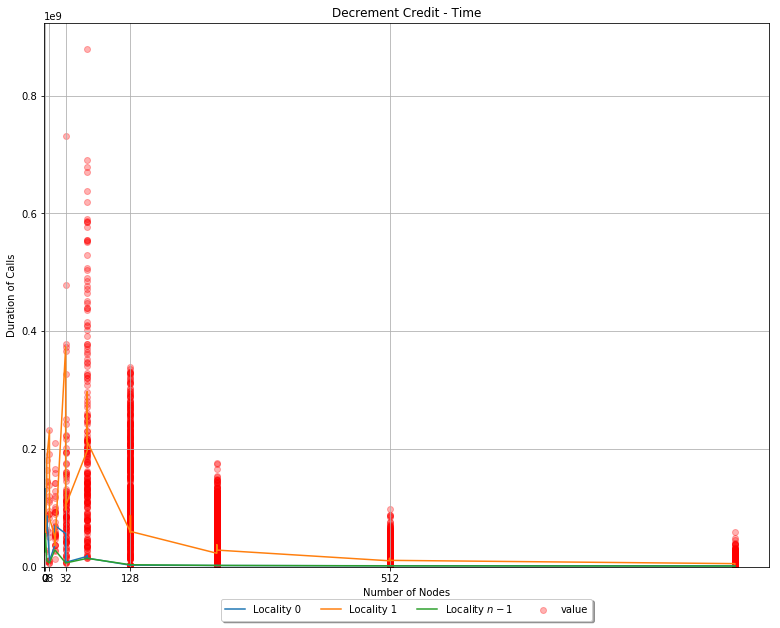

In [21]:
crt = d[(d.sys=='agas') & (d.proc=='decrement_credit') & (d.type=='time')]

plt.figure(figsize=(13, 10))
plt.scatter(crt.nodes, crt.value, c='r', alpha=.3)
#
t = crt[crt.locality==0]
plt.plot(t.nodes, t.value, label='Locality 0')
#
t = crt[crt.locality==1]
plt.plot(t.nodes, t.value, label='Locality 1')
#
t = crt.groupby('nodes', as_index=False).last()
plt.plot(t.nodes, t.value, label='Locality $n - 1$')
#
plt.grid()

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
plt.title('Decrement Credit - Time')
plt.xlabel('Number of Nodes')
plt.ylabel('Duration of Calls')

plt.gca().xaxis.set_major_locator(ticker.LogLocator(base=2))
plt.gca().set_xlim(left=0.)
plt.gca().set_ylim(bottom=0.)

[^ TOC ^](#Counters)

---

## AGAS Cache

### AGAS Cache Hit Rate

* $\textit{hits}: \mathtt{/agas\{locality\#*/total\}/count/cache/hits}$
* $\textit{misses}: \mathtt{/agas\{locality\#*/total\}/count/cache/misses}$

$$
\textit{miss rate} = \frac{\textit{misses}}{\textit{misses} + \textit{hits}}
$$

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


(0.0, 1.0463009237878382)

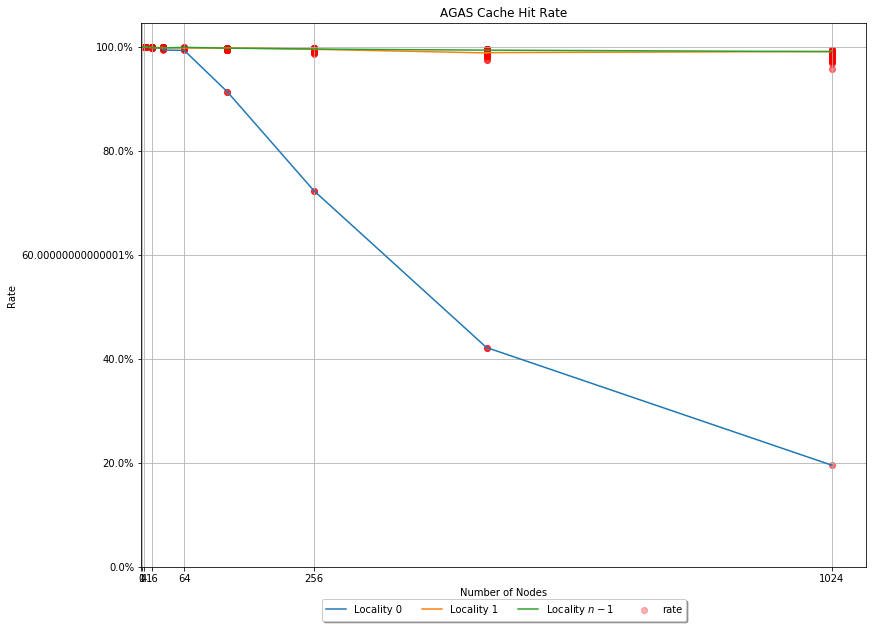

In [22]:
crt_h = d[(d.sys=='agas') & (d.proc=='cache.hits') & (d.type=='count')]
crt_m = d[(d.sys=='agas') & (d.proc=='cache.misses') & (d.type=='count')]

crt_m = crt_m.set_index(crt_h.index)

crt = crt_h[['nodes', 'value', 'locality']]
#crt.is_copy = False # Disable the warning
crt['rate'] = crt_h.value / (crt_h.value + crt_m.value)

plt.figure(figsize=(13, 10))
plt.scatter(crt.nodes, crt.rate, c='r', alpha=.3)

t = crt[crt.locality==0]
plt.plot(t.nodes, t.rate, label='Locality 0')

t = crt[crt.locality==1]
plt.plot(t.nodes, t.rate, label='Locality 1')

t = crt.groupby('nodes', as_index=False).last()
plt.plot(t.nodes, t.rate, label='Locality $n - 1$')

plt.grid()

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
plt.title('AGAS Cache Hit Rate')
plt.xlabel('Number of Nodes')
plt.ylabel('Rate')

plt.gca().xaxis.set_major_locator(ticker.LogLocator(base=2))
plt.gca().set_xlim(left=0.)
plt.gca().yaxis.set_major_formatter(PercentFormatter)
plt.gca().set_ylim(bottom=0.)

[^ TOC ^](#Counters)

### Insert Entry

(0.0, 207388650.00607064)

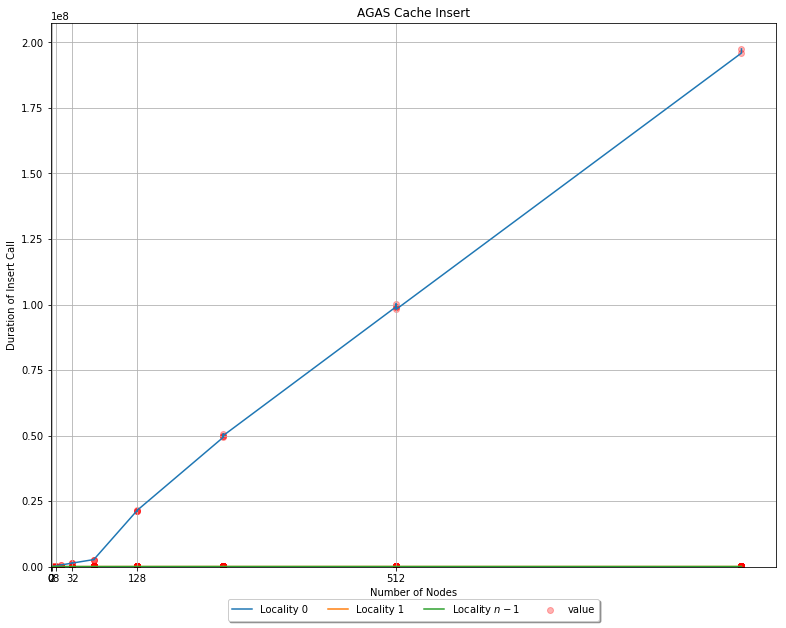

In [23]:
crt = d[(d.sys=='agas') & (d.proc=='cache.insert_entry') & (d.type=='time')]

plt.figure(figsize=(13, 10))
plt.scatter(crt.nodes, crt.value, c='r', alpha=.3)

t = crt[crt.locality==0]
plt.plot(t.nodes, t.value, label='Locality 0')

t = crt[crt.locality==1]
plt.plot(t.nodes, t.value, label='Locality 1')
#
t = crt.groupby('nodes', as_index=False).last()
plt.plot(t.nodes, t.value, label='Locality $n - 1$')
#
plt.grid()

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
plt.title('AGAS Cache Insert')
plt.xlabel('Number of Nodes')
plt.ylabel('Duration of Insert Call')

plt.gca().xaxis.set_major_locator(ticker.LogLocator(base=2))
plt.gca().set_xlim(left=0.)
plt.gca().set_ylim(bottom=0.)

[^ TOC ^](#Counters)

### Erase Entry

(0.0, 0.006070640176600442)

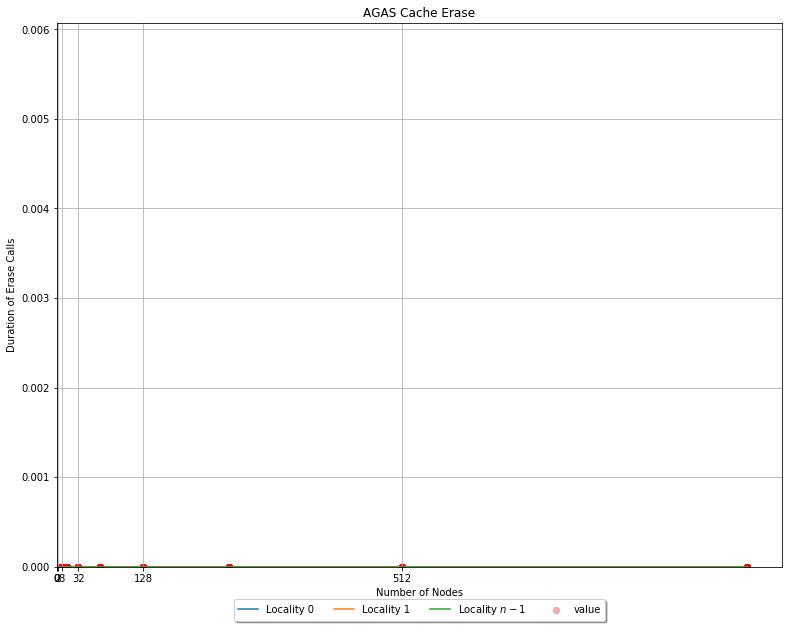

In [24]:
crt = d[(d.sys=='agas') & (d.proc=='cache.erase_entry') & (d.type=='time')]

plt.figure(figsize=(13, 10))
plt.scatter(crt.nodes, crt.value, c='r', alpha=.3)

t = crt[crt.locality==0]
plt.plot(t.nodes, t.value, label='Locality 0')

t = crt[crt.locality==1]
plt.plot(t.nodes, t.value, label='Locality 1')
#
t = crt.groupby('nodes', as_index=False).last()
plt.plot(t.nodes, t.value, label='Locality $n - 1$')
#
plt.grid()

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
plt.title('AGAS Cache Erase')
plt.xlabel('Number of Nodes')
plt.ylabel('Duration of Erase Calls')

plt.gca().xaxis.set_major_locator(ticker.LogLocator(base=2))
plt.gca().set_xlim(left=0.)
plt.gca().set_ylim(bottom=0.)

[^ TOC ^](#Counters)

### Get Entry

(0.0, 480072600.0060706)

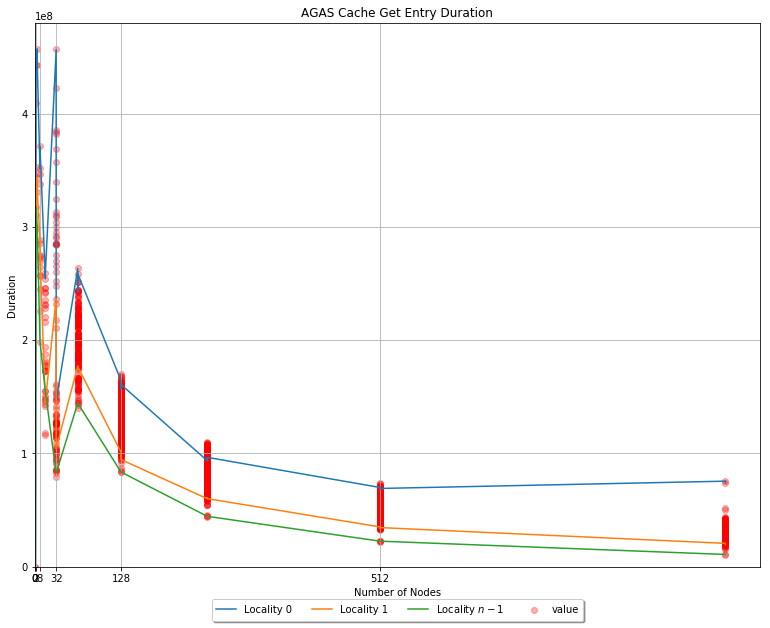

In [25]:
crt = d[(d.sys=='agas') & (d.proc=='cache.get_entry') & (d.type=='time')]

plt.figure(figsize=(13, 10))
plt.scatter(crt.nodes, crt.value, c='r', alpha=.3)

t = crt[crt.locality==0]
plt.plot(t.nodes, t.value, label='Locality 0')

t = crt[crt.locality==1]
plt.plot(t.nodes, t.value, label='Locality 1')
#
t = crt.groupby('nodes', as_index=False).last()
plt.plot(t.nodes, t.value, label='Locality $n - 1$')
#
plt.grid()

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
plt.title('AGAS Cache Get Entry Duration')
plt.xlabel('Number of Nodes')
plt.ylabel('Duration')

plt.gca().xaxis.set_major_locator(ticker.LogLocator(base=2))
plt.gca().set_xlim(left=0.)
plt.gca().set_ylim(bottom=0.)

[^ TOC ^](#Counters)

### Update Entry

(0.0, 137576.25607064017)

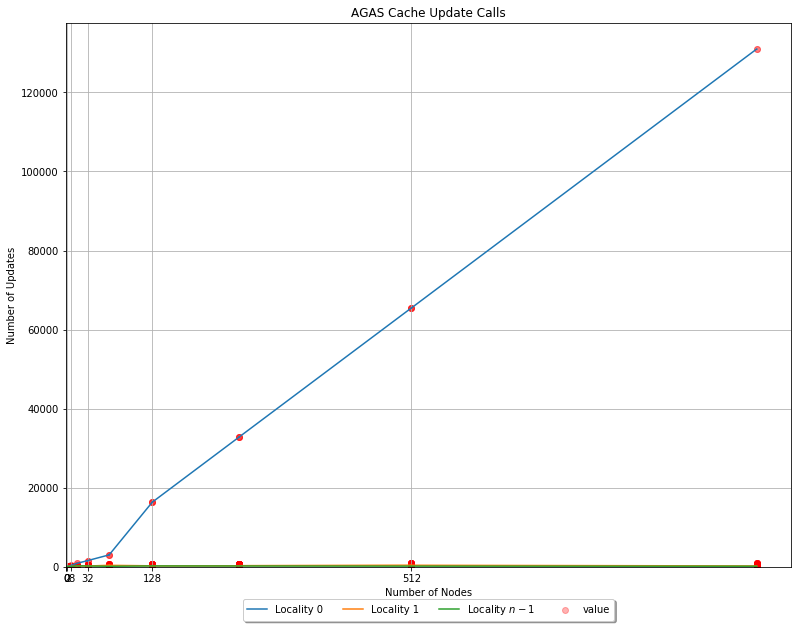

In [26]:
crt = d[(d.sys=='agas') & (d.proc=='cache.update_entry') & (d.type=='count')]

plt.figure(figsize=(13, 10))
plt.scatter(crt.nodes, crt.value, c='r', alpha=.3)

t = crt[crt.locality==0]
plt.plot(t.nodes, t.value, label='Locality 0')

t = crt[crt.locality==1]
plt.plot(t.nodes, t.value, label='Locality 1')
#
t = crt.groupby('nodes', as_index=False).last()
plt.plot(t.nodes, t.value, label='Locality $n - 1$')
#
plt.grid()

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
plt.title('AGAS Cache Update Calls')
plt.xlabel('Number of Nodes')
plt.ylabel('Number of Updates')

plt.gca().xaxis.set_major_locator(ticker.LogLocator(base=2))
plt.gca().set_xlim(left=0.)
plt.gca().set_ylim(bottom=0.)

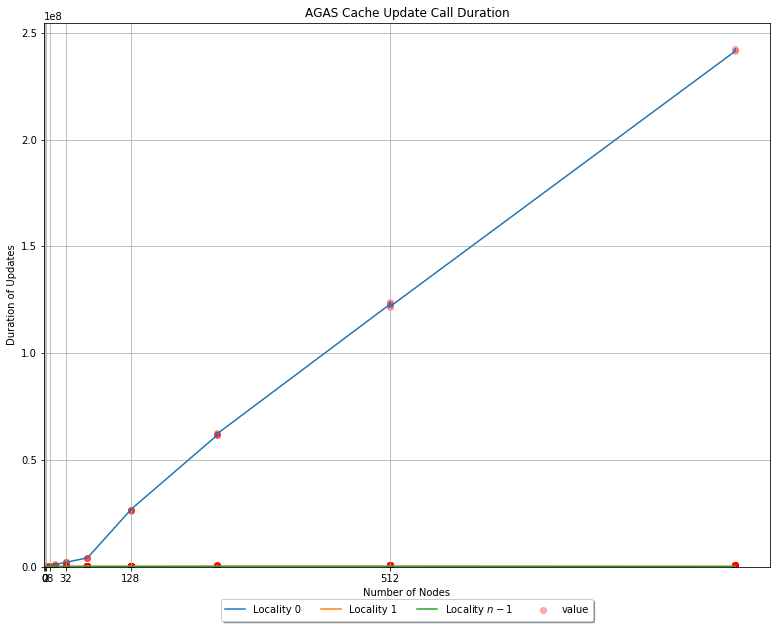

In [27]:
crt = d[(d.sys=='agas') & (d.proc=='cache.update_entry') & (d.type=='time')]

if crt.size > 0:
    plt.figure(figsize=(13, 10))
    plt.scatter(crt.nodes, crt.value, c='r', alpha=.3)

    t = crt[crt.locality==0]
    plt.plot(t.nodes, t.value, label='Locality 0')

    t = crt[crt.locality==1]
    plt.plot(t.nodes, t.value, label='Locality 1')
    #
    t = crt.groupby('nodes', as_index=False).last()
    plt.plot(t.nodes, t.value, label='Locality $n - 1$')
    #
    plt.grid()

    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
    plt.title('AGAS Cache Update Call Duration')
    plt.xlabel('Number of Nodes')
    plt.ylabel('Duration of Updates')

    plt.gca().xaxis.set_major_locator(ticker.LogLocator(base=2))
    plt.gca().set_xlim(left=0.)
    plt.gca().set_ylim(bottom=0.)

---

# Miscellaneous

### Save Dataset to disk

```python
df.to_hdf('./pfx_data.hdf', 'table', mode='w', table=True)
```

[^ TOC ^](#Counters)